#Importing libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import statistics
import math

#Loading dataset after connecting g-drive to google colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Hirakud Data/Hirakud_inflow_daily_1995_2015.csv', index_col = 'Date', parse_dates = True)
data

,Inflow
Date,
1995-01-07,339.24500
1995-02-07,226.61700
1995-03-07,389.20200
1995-04-07,427.63200
1995-05-07,488.35000
...,...
2015-12-27,49.13520
2015-12-28,46.67136
2015-12-29,91.24704


#Train-Test split


In [4]:
data_train = data.iloc[:5663]
data_train

,Inflow
Date,
1995-01-07,339.2450
1995-02-07,226.6170
1995-03-07,389.2020
1995-04-07,427.6320
1995-05-07,488.3500
...,...
2010-12-27,132.3680
2010-12-28,107.6730
2010-12-29,69.7522


In [5]:
data_test = data.iloc[5663:]
data_test

,Inflow
Date,
2011-01-01,27.18720
2011-02-01,38.23200
2011-03-01,47.09620
2011-04-01,0.00000
2011-05-01,0.00000
...,...
2015-12-27,49.13520
2015-12-28,46.67136
2015-12-29,91.24704


#Converting and reshaping data into a 1-D sequential array

In [6]:
numpy_data_train = data_train.to_numpy()
numpy_data_train

array([[339.245 ],
       [226.617 ],
       [389.202 ],
       ...,
       [ 69.7522],
       [ 89.0947],
       [ 51.1459]])

In [7]:
numpy_data_test = data_test.to_numpy()
numpy_data_test

array([[27.1872 ],
       [38.232  ],
       [47.0962 ],
       ...,
       [91.24704],
       [66.80688],
       [86.74416]])

In [8]:
numpy_data_train.shape, numpy_data_test.shape

((5663, 1), (1826, 1))

### Reshaping training and testing data into a sequence

In [9]:
raw_seq_train = numpy_data_train.reshape([-1])
raw_seq_train

array([339.245 , 226.617 , 389.202 , ...,  69.7522,  89.0947,  51.1459])

In [10]:
raw_seq_test = numpy_data_test.reshape([-1])
raw_seq_test

array([27.1872 , 38.232  , 47.0962 , ..., 91.24704, 66.80688, 86.74416])

#Data preparation for time-series forecasting 

In [11]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps, lead):
  
	X, y = list(), list()

	for i in range(len(sequence)):
		
    # find the end of this pattern
		end_i = i + n_steps
		
    # to check if we are beyond the sequence
		if end_i + (lead-1)> len(sequence)-1:
			break
		
    # to gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_i], sequence[end_i + (lead-1)]
		X.append(seq_x)
		y.append(seq_y)
  
	return np.array(X), np.array(y)

In [12]:
n_steps = 7
lead = 3
X_train, y_train = split_sequence(raw_seq_train, n_steps, lead)
X_test, y_test = split_sequence(raw_seq_test, n_steps, lead)

In [13]:
X_train, y_train, X_train.shape, y_train.shape

(array([[339.245  , 226.617  , 389.202  , ..., 488.35   , 536.664  ,
         579.512  ],
        [226.617  , 389.202  , 427.632  , ..., 536.664  , 579.512  ,
         317.524  ],
        [389.202  , 427.632  , 488.35   , ..., 579.512  , 317.524  ,
         490.814  ],
        ...,
        [109.768  ,  78.673  , 105.634  , ...,  75.7277 ,  87.6221 ,
           8.01456],
        [ 78.673  , 105.634  ,  53.3832 , ...,  87.6221 ,   8.01456,
         132.368  ],
        [105.634  ,  53.3832 ,  75.7277 , ...,   8.01456, 132.368  ,
         107.673  ]]),
 array([270.201 , 393.082 , 441.424 , ...,  69.7522,  89.0947,  51.1459]),
 (5654, 7),
 (5654,))

In [14]:
X_test, y_test, X_test.shape, y_test.shape

(array([[ 27.1872 ,  38.232  ,  47.0962 , ...,   0.     ,  54.1195 ,
         105.69   ],
        [ 38.232  ,  47.0962 ,   0.     , ...,  54.1195 , 105.69   ,
           0.     ],
        [ 47.0962 ,   0.     ,   0.     , ..., 105.69   ,   0.     ,
          13.3954 ],
        ...,
        [  0.     ,   6.06048,  55.98864, ...,  87.90528, 148.79328,
           0.     ],
        [  6.06048,  55.98864,  59.0472 , ..., 148.79328,   0.     ,
          49.1352 ],
        [ 55.98864,  59.0472 ,  87.90528, ...,   0.     ,  49.1352 ,
          46.67136]]),
 array([74.5382 , 13.5653 ,  0.     , ..., 91.24704, 66.80688, 86.74416]),
 (1817, 7),
 (1817,))



#Normalizing dataset


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(X_train)
scaler.fit(X_test)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#CNN-LSTM model

In [16]:
model = keras.Sequential([
                          # convolution and pooling

                          # Layer 1
                          keras.layers.Conv1D(filters = 100, kernel_size = 2, strides = 1, activation = 'relu', input_shape = (n_steps, 1)),

                          # Layer 2
                          keras.layers.Conv1D(filters = 85, kernel_size = 2, strides = 1, activation = 'relu'),

                          # Layer 3
                          keras.layers.Conv1D(filters = 60, kernel_size = 2, strides = 1, activation = 'relu'),

                          # Layer 4
                          keras.layers.Conv1D(filters = 35, kernel_size = 2, strides = 1, activation = 'relu'),

                          # Layer 5
                          keras.layers.Conv1D(filters = 5, kernel_size = 2, strides = 1, activation = 'relu'),
                          
                          # MaxPooling1D
                          # keras.layers.MaxPool1D(pool_size = 2),
                          # keras.layers.Flatten(),
                          keras.layers.LSTM(50, activation = 'relu'),

                          keras.layers.Dense(1)
])

adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.99, beta_2=0.99, epsilon=1e-07)
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min')

model.compile(
    optimizer = adam,
    loss = 'mae',
    metrics = ['mae']
)


model.fit(X_train, y_train, validation_split = 0.1, epochs = 500, batch_size = 800)

Epoch 1/500
7/7 [==============================] - 5s 255ms/step - loss: 918.6010 - mae: 918.6010 - val_loss: 811.2517 - val_mae: 811.2517
Epoch 2/500
7/7 [==============================] - 1s 87ms/step - loss: 918.5657 - mae: 918.5657 - val_loss: 811.2051 - val_mae: 811.2051
Epoch 3/500
7/7 [==============================] - 1s 85ms/step - loss: 918.4965 - mae: 918.4965 - val_loss: 811.1119 - val_mae: 811.1119
Epoch 4/500
7/7 [==============================] - 1s 81ms/step - loss: 918.3593 - mae: 918.3593 - val_loss: 810.9255 - val_mae: 810.9255
Epoch 5/500
7/7 [==============================] - 1s 81ms/step - loss: 918.0833 - mae: 918.0833 - val_loss: 810.5540 - val_mae: 810.5540
Epoch 6/500
7/7 [==============================] - 1s 90ms/step - loss: 917.5350 - mae: 917.5350 - val_loss: 809.8268 - val_mae: 809.8268
Epoch 7/500
7/7 [==============================] - 1s 86ms/step - loss: 916.4678 - mae: 916.4678 - val_loss: 808.4071 - val_mae: 808.4071
Epoch 8/500
7/7 [================

#Predicting on X_test

In [17]:
y_predicted = model.predict(X_test)
y_predicted

array([[43.13298 ],
       [40.08992 ],
       [27.245848],
       ...,
       [57.20957 ],
       [49.848724],
       [44.322174]], dtype=float32)

In [18]:
y_predicted = y_predicted.flatten(order='C')

In [19]:
y_predicted[100], y_test.dtype

(56.632793, dtype('float64'))

#Calculating performance metrics

###MAE

In [20]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_predicted)

453.809588074969

###Evol(%)

In [21]:
def error_vol(observed, predicted):
  error_volume = ((np.sum(predicted)/np.sum(observed)) - 1)*100
  return error_volume

evol = error_vol(y_test, y_predicted) 
evol

-25.71662548664586

###RSR

In [22]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_predicted, squared=False)
def variance(data):
  n = len(data)
  mean = sum(data) / n
  deviations = [(x - mean) ** 2 for x in data]
  variance = sum(deviations) / n
  return variance
vr = variance(y_test)
std_dev = math.sqrt(vr)
rsr = rmse/std_dev
rsr

0.6873530730097437

###NSE(%)

In [23]:
def nse(predictions, targets):
  val = 1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2))
  return val

NSE = nse(y_predicted, y_test)*100
NSE

52.75457530240618

###r


In [24]:
def correlation_coef(observed, predicted):
  obs_mean = np.mean(observed)
  pred_mean = np.mean(predicted)

  numerator = np.sum((observed - obs_mean)*(predicted - pred_mean))
  denominator = np.sqrt(np.sum((observed - obs_mean)**2)*np.sum((predicted - pred_mean)**2))
  r = numerator/denominator
  return r

r = correlation_coef(y_test, y_predicted)
r

0.74694630791744

#Plots

<function matplotlib.pyplot.show>

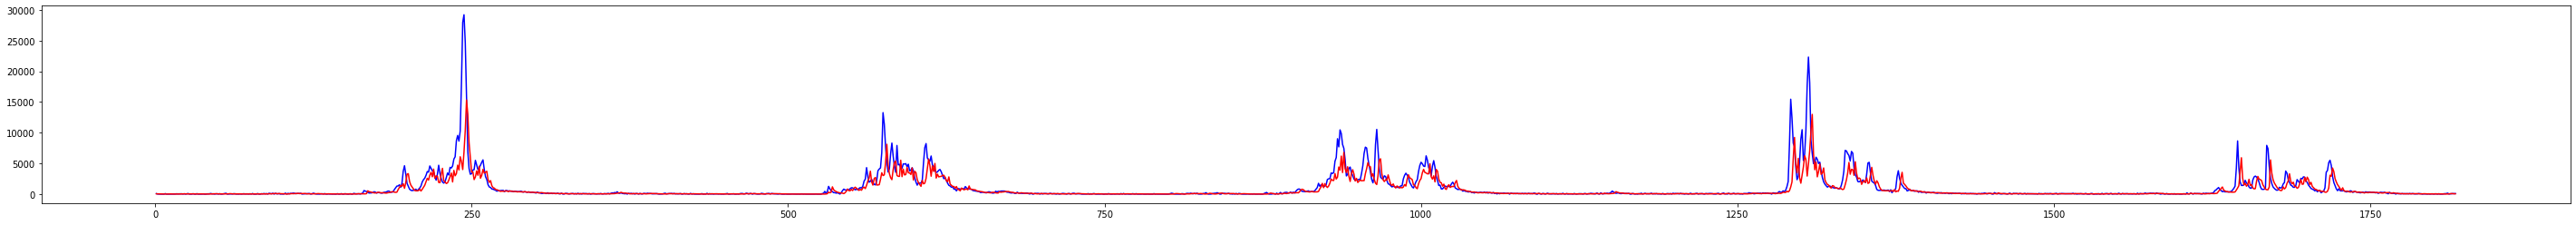

In [25]:
x_plot = np.arange(1, len(y_test) + 1, 1)

f = plt.figure()
f.set_figwidth(50)
f.set_figheight(4)

plt.plot(x_plot, y_test, 'b')
plt.plot(x_plot, y_predicted, 'r')

plt.show

<function matplotlib.pyplot.show>

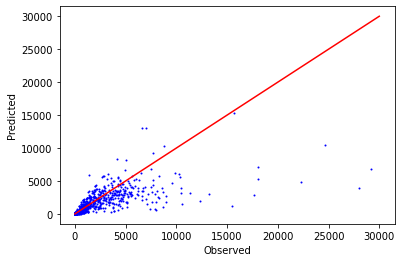

In [26]:
plt.xlabel('Observed')
plt.ylabel('Predicted')

plt.scatter(y_test, y_predicted, c = 'b', s = 1)

x0 = np.linspace(0,30000,1000)
y0 = x0
plt.plot(x0, y0, 'r')

plt.show